**PySDS Week 03 Day 01 v.1 - Exercise - Reddit data collection**

In [1]:
# Exercise 1. The fastest subreddit in the west. 

# For the following subreddits, download the first 200 posts that appear, 
# cleaning out any stickied post (which will ruin this exercise). Then calculate the time
# range between the most recent post and the latest post.
# Plot the time differences on a bar graph. 

subreddits = ["pokemon", 
              "muppets", 
              "UNBGBBIIVCHIDCTIICBG", 
              "lego", 
              "TheSimpsons", 
              "relationship_advice",
              "whatswrongwithyourdog",
              "subredditoftheday",
              "liverpoolfc"]


################################
# Answer Below Here
import praw
import json
import time
import matplotlib.pyplot as plt

keys = json.loads(open("keys.json").read()) # authenticate
reddit = praw.Reddit(user_agent='Comment Extraction (by /u/berniehogan)',
                     client_id=keys['client_id'], 
                     client_secret=keys['client_secret'],
                     username=keys['username'], 
                     password=keys['password'])

submissions = {} # nonstickied
submissions_s= {} # including stickied

for i in subreddits:
    print('Getting data from subreddit:', i)
    submissions[i] = [x for x in reddit.subreddit(i).hot(limit=200) if not x.stickied] # list comprehension for getting submission data
    submissions_s[i] = [x for x in reddit.subreddit(i).hot(limit=200)]
    time.sleep(1)

tdiff = []
tdiff_s = []
for i in subreddits: # get the difference in min vs max post time for each subreddit
    tdiff.append(max([x.created_utc for x in submissions[i]])-min([x.created_utc for x in submissions[i]]))
    tdiff_s.append(max([x.created_utc for x in submissions_s[i]])-min([x.created_utc for x in submissions_s[i]]))

    
#######################
# Peer review comments below here




Getting data from subreddit: pokemon
Getting data from subreddit: muppets
Getting data from subreddit: UNBGBBIIVCHIDCTIICBG
Getting data from subreddit: lego
Getting data from subreddit: TheSimpsons
Getting data from subreddit: relationship_advice
Getting data from subreddit: whatswrongwithyourdog
Getting data from subreddit: subredditoftheday
Getting data from subreddit: liverpoolfc


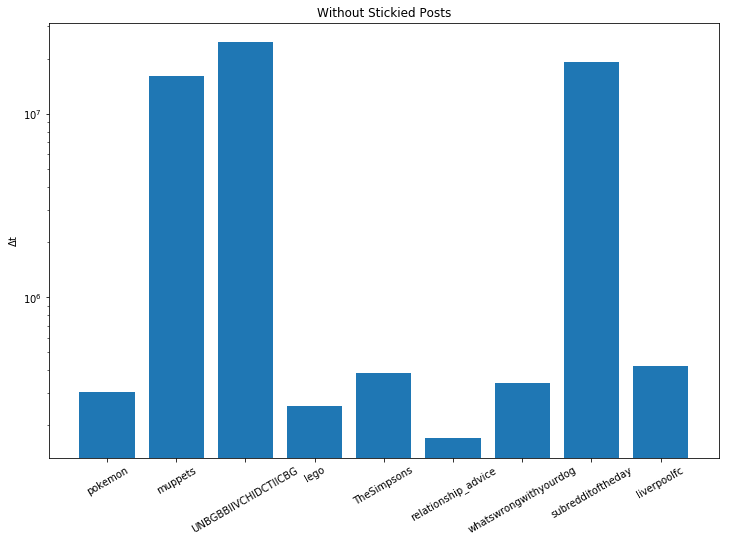

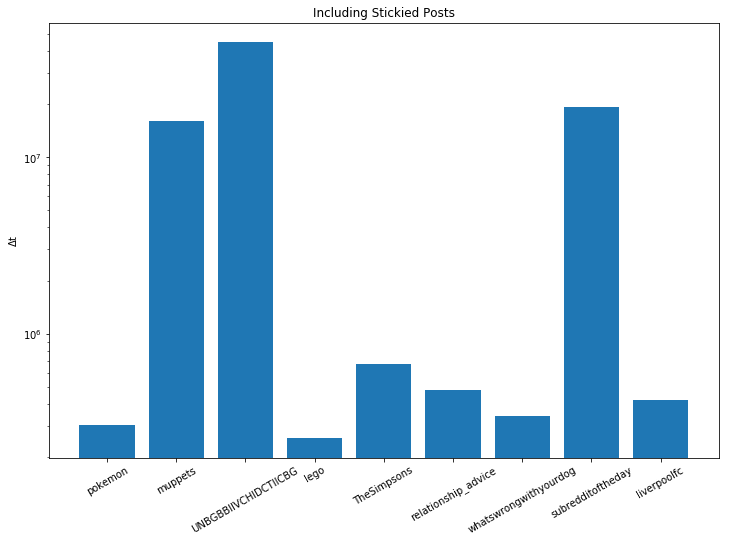

In [9]:
# plots 
plt.figure(figsize= [12,8])
plt.bar(subreddits, tdiff, log=True)
plt.ylabel(r'$\Delta$t')
plt.title('Without Stickied Posts')
plt.xticks(rotation=30)
plt.show()


plt.figure(figsize= [12,8])
plt.bar(subreddits, tdiff_s, log=True)
plt.ylabel(r'$\Delta$t')
plt.title('Including Stickied Posts')
plt.xticks(rotation=30)
plt.show()
#########

In [6]:
# Exercise 2.  Testing Gonzalez-Bailon's theories, kinda
# Using my code for how to build a comment tree, select two submissions
# One that is from a political subreddit of any kind (politics / ukpolitics / etc...)
# One that is from a video game or collectible dolls. 
# Both should have roughly the same number of comments (+/- 100)

# Now report the max and the average in-degree at depth = 0 and report the max and average thread depth. 
# This can be done without networkx by grouping the level-1 depth comments and counting the parent
# as in, x[x[depth] = 1], then x.groupby(parent_id).count() -> merge back into orignal data and get average.
# or, yknow, ,use networkx, calculate indegree and merge back in. 
# You don't need to use networkx for the depth, just get the average of the depth, the higher the number the
# the deeper the average comment. 


################################
# Answer Below Here
import networkx as nx 
import pandas as pd

def buildgraph(post_id):
    '''
    Build a reddit comment graph based on a particular post id
    Based on prior code from lecture.
    '''
    G = nx.DiGraph()
    submission = reddit.submission(post_id)
    node_set = set([])
    # submission.comments.replace_more(limit=None)
    for i in submission.comments.list():
        try:
            G.add_node(i.id, depth=i.depth,name=i.author.name)
        except AttributeError: 
            G.add_node(i.id, depth=i.depth,name="[Deleted]")
        node_set.add(i.id)

    for i in submission.comments.list():
        if i.parent_id and i.parent_id[3:] in node_set:
            G.add_edge(i.id,i.parent_id[3:])
    
    return G

ukpolsub = '9q3mar'
pokemonsub = '9qksf7'

posts = {ukpolsub:buildgraph(ukpolsub), pokemonsub:buildgraph(pokemonsub)}

for k, G in posts.items(): # For both posts
    deg_dict = pd.DataFrame.from_dict(dict(G.in_degree()),orient="index",columns=["in_degree"]) # create df for node indegree and depth
    deg_dict['depth'] = pd.Series(dict([(i,G.nodes[i]['depth']) for i in G.nodes])) 

    maxi = deg_dict[deg_dict['depth']==0]['in_degree'].max() # get max and mean in degree at depth 0
    meani = deg_dict[deg_dict['depth']==0]['in_degree'].mean()

    maxd = deg_dict['depth'].max() # get max and mean depth
    meand = deg_dict['depth'].mean()

    # print output
    print('For the post:\n%s\nThe max indegree at comment depth=0 is %d, the mean indegree at depth=0 is %.2f'
          %(reddit.submission(k).title, maxi, meani))
    
    print('For the post:\n%s\nThe max comment depth is %d, the mean comment depth is %.2f\n'
          %(reddit.submission(k).title, maxd, meand))


################################
# Peer review comments below here






For the post:
Nicola Sturgeon - "This morning I’ve seen quotes from Tories to the effect that PM is ‘entering the killing zone’, faces ‘assassination’ and should take ‘her own noose’ to a meeting. Few disagree with her more than I do, but language like this debases politics. Get a grip, Tories."
The max indegree at comment depth=0 is 10, the mean indegree at depth=0 is 1.29
For the post:
Nicola Sturgeon - "This morning I’ve seen quotes from Tories to the effect that PM is ‘entering the killing zone’, faces ‘assassination’ and should take ‘her own noose’ to a meeting. Few disagree with her more than I do, but language like this debases politics. Get a grip, Tories."
The max comment depth is 10, the mean comment depth is 3.30

For the post:
Some Legendary Pokemon According to Autocorrect
The max indegree at comment depth=0 is 10, the mean indegree at depth=0 is 0.48
For the post:
Some Legendary Pokemon According to Autocorrect
The max comment depth is 8, the mean comment depth is 1.09

